# Galaxy classifier
## Import libraries, path and labels dict
https://www.kaggle.com/addisonkendalllr/galaxydataset

In [64]:
import numpy as np 
import pandas as pd 

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pk
import pprint
import time
from random import randint

from PIL import Image
from skimage.io import imread
from skimage.transform import resize

from ipywidgets import IntProgress
from IPython.display import display
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

Train images must be in ~/image/label_x folder

In [65]:
img_files = np.array(glob("images/*"))
img_files

array(['images\\edge', 'images\\other', 'images\\smooth',
       'images\\spiral'], dtype='<U13')

In [66]:
# Create dict of breeds
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

## Image pre-processing

In [81]:
# Define image size to be transfered to the CNN
size = (128, 128)

In [82]:
# Load and resize image + store in array
def load_images(folder):
    images = []
    target = []
    for i in range(len(folder)):
        
        # print progress and number of files   
        num_file = len(os.listdir(folder[i]))
        print('label',str(i)+'/'+str(len(folder)-1)+' path:',folder[i], str(num_file)+" files")
        
        # Progress bar
        max_count = num_file
        f = IntProgress(min=0, max=max_count) # instantiate the bar
        display(f) # display the bar
        
        # load and resize images from a folder
        for filename in os.listdir(folder[i]):
            f.value += 1
            img = imread(os.path.join(folder[i], filename), as_gray=False)
            if img is not None:
                # resize image
                img = resize(img, size, mode='reflect')
                # convert to np array
                img = np.asarray(img)
                # append image list and target list
                images.append(img)
                target.append(i)       
                
    return images, target

In [83]:
X, y = load_images(img_files)

label 0/3 path: images\edge 100 files


IntProgress(value=0)

label 1/3 path: images\other 100 files


IntProgress(value=0)

label 2/3 path: images\smooth 100 files


IntProgress(value=0)

label 3/3 path: images\spiral 100 files


IntProgress(value=0)

image 119
image dimension: (128, 128, 3)


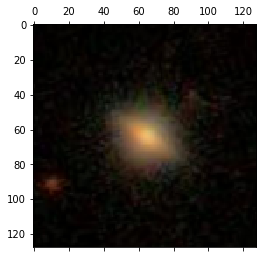

In [84]:
nb_images = sum([len(os.listdir(img_files[0])) for i in range(len(img_files))])
random_image_idx = randint(0, nb_images-1)
print("image",random_image_idx)

def display_example(images, id_img):
    # display image that the CNN will see
    plt.matshow(images[id_img]) 
    print('image dimension:',images[id_img].shape)
    
display_example(X, random_image_idx)

## CNN

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle = True, test_size=0.2, random_state=42)

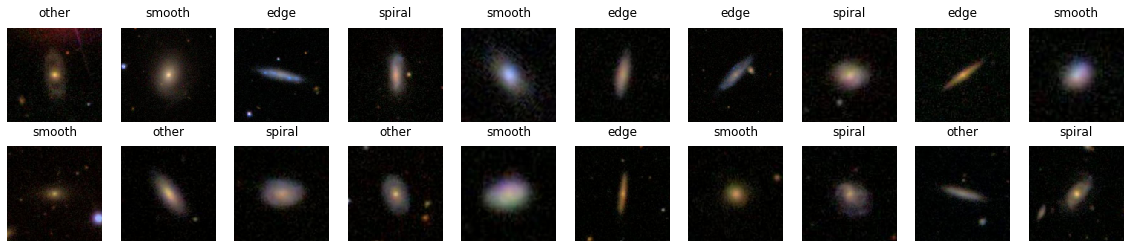

In [86]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.matshow(X_train[idx], cmap='gray') 
    ax.set_title(target_dict[y_train[idx]])
    ax.axis('off')

In [87]:
# Image augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.01, # shift images horizontaly x% of total width
    height_shift_range=0.01, # shift images vertically x% of total width
    horizontal_flip=False # randomly flip images horizontally
)

In [88]:
y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

In [89]:
X_train = np.asarray(X_train)
print('X_train shape:',X_train.shape)

y_train = np.asarray(y_train)
print('y_train shape:',y_train.shape)

X_test = np.asarray(X_test)
print('X_test shape:',X_test.shape)

y_test = np.asarray(y_test)
print('y_test shape:',y_test.shape)

X_train shape: (320, 128, 128, 3)
y_train shape: (320, 4)
X_test shape: (80, 128, 128, 3)
y_test shape: (80, 4)


In [93]:
# Home-made model

model = Sequential()
# 32 2x2 kernels
model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu', input_shape=X_train.shape[-3:]))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# 64 2x2 kernels
model.add(Conv2D(filters=64, kernel_size=(2, 2), padding='same', activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.2))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.2))
# Final categorization with softmax
model.add(Dense(y_train.shape[-1], activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      416       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)              

In [94]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [95]:
# train the model
early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
checkpointer = ModelCheckpoint(filepath='galaxy.cnn.best.hdf5', verbose=1, save_best_only=True)
batch_size = 32

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=10,
    validation_data=(X_test, y_test), 
    callbacks=[checkpointer, early_stopper],
    verbose=2, 
    shuffle=True
)

Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.37417, saving model to galaxy.cnn.best.hdf5
10/10 - 33s - loss: 1.6976 - acc: 0.2688 - val_loss: 1.3742 - val_acc: 0.3375
Epoch 2/10

Epoch 00002: val_loss improved from 1.37417 to 1.36720, saving model to galaxy.cnn.best.hdf5
10/10 - 32s - loss: 1.3330 - acc: 0.3688 - val_loss: 1.3672 - val_acc: 0.2875
Epoch 3/10

Epoch 00003: val_loss improved from 1.36720 to 1.30244, saving model to galaxy.cnn.best.hdf5
10/10 - 29s - loss: 1.2837 - acc: 0.3875 - val_loss: 1.3024 - val_acc: 0.4125
Epoch 4/10

Epoch 00004: val_loss improved from 1.30244 to 1.27947, saving model to galaxy.cnn.best.hdf5
10/10 - 29s - loss: 1.1730 - acc: 0.4625 - val_loss: 1.2795 - val_acc: 0.3125
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.27947
10/10 - 29s - loss: 1.1201 - acc: 0.5281 - val_loss: 1.3109 - val_acc: 0.3375
Epoch 6/10

Epoch 00006: val_loss improved from 1.27947 to 1.26741, saving model to galaxy.cnn.best.hdf5
10/10 - 29s - loss: 1.0637

In [96]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 45.0000%


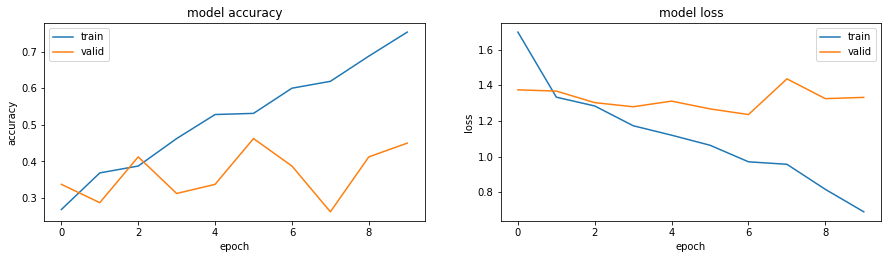

In [97]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

## Test classifier

In [98]:
img_files = np.array(glob("images/*"))
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

In [99]:
trained_model = tensorflow.keras.models.load_model('galaxy.cnn.best.hdf5')

In [100]:
test_img_files = np.array(glob("test_files"))
test_img_files

array(['test_files'], dtype='<U10')

In [101]:
test_features, _ = load_images(test_img_files)

label 0/0 path: test_files 80 files


IntProgress(value=0, max=80)

In [102]:
test_features = np.asarray(test_features)
print('test_features shape:',test_features.shape)

test_features shape: (80, 128, 128, 3)


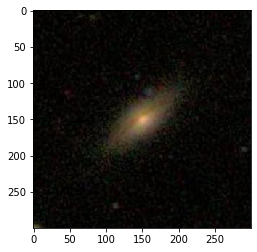

Predicted class: edge


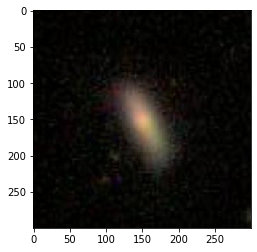

Predicted class: smooth


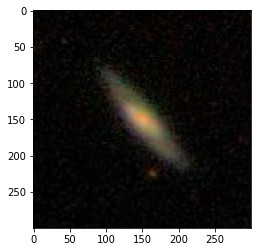

Predicted class: edge


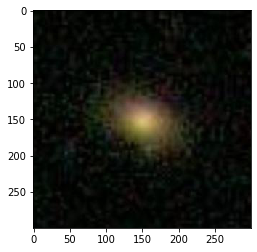

Predicted class: smooth


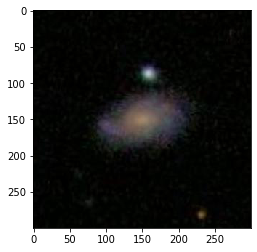

Predicted class: spiral


In [106]:
def print_class(features, idx):
    img = imread(os.path.join('test_files', os.listdir(test_img_files[0])[idx]), as_gray=False)
    plt.imshow(img)
    plt.show()
    # Results into dataframe
    result = trained_model.predict_classes(features[idx].reshape(1,128,128,3))
    return 'Predicted class: '+target_dict[result[0]]

# print i examples in the test images list
for i in np.random.choice(range(len(os.listdir(test_img_files[0]))-1), 5, replace=False):
    print(print_class(test_features, i))